In [1]:
import argparse
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
import time
import torch
import torch.nn as nn
import utils
from torch.autograd import Variable
import cPickle
from language_model import WordEmbedding, QuestionEmbedding
import base_model
import numpy as np
from dataset import Dictionary, VQAFeatureDataset
import train
import imageModel

torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.backends.cudnn.benchmark = True
constructor = 'build_%s' % 'baseline0_newatt'
dictionary = Dictionary.load_from_file('data/dictionary.pkl')

/home/shared/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


loading dictionary from data/dictionary.pkl


In [2]:
import pickle

dictionary = Dictionary.load_from_file('data/dictionary.pkl')
questionIds = pickle.load(open('data/goodQuestions.pkl',"rb"))
print "Fetching eval data"
imageLoader = imageModel.ImageLoader("data/val2014img", "val")
adv_dset = VQAFeatureDataset('valSample', 'valSample', dictionary,questionIds = questionIds)

answer_path = os.path.join('data', 'cache', '%s_target.pkl' % 'train')
answers = cPickle.load(open(answer_path, 'rb'))
answers = sorted(answers, key=lambda x: x['question_id'])
print(len(answers))
# train_dset = VQAFeatureDataset('train','train',dictionary)
# adv_dset = VQAFeatureDataset('val', 'val', dictionary)
# parser = argparse.ArgumentParser()
# parser.add_argument('--num_hid', type=int, default=1024)
# parser.add_argument('--model', type=str, default='baseline0_newatt')
# parser.add_argument('--load_path', type=str, default='/home/vvayfarer/cs231nvqa2/saved_models/resnet152_49_2/')
# args = parser.parse_args()
class Args:
    def __init__(self):
        self.num_hid = 1024
        self.model = 'baseline0_newatt'
        self.load_path = '/home/vvayfarer/cs231nvqa2/saved_models/resnet152_49_2/'
args = Args()
# model = imageModel.getCombinedModel(args, adv_dset)
constructor = 'build_%s' % args.model
model = getattr(base_model, constructor)(adv_dset, 1024).cuda()
model.w_emb.init_embedding('data/glove6b_init_300d.npy')
wembed = model.w_emb
model = nn.DataParallel(model).cuda()
# load_p = '/home/vvayfarer/cs231nvqa2/saved_models/milestone'
load_path = os.path.join(args.load_path, 'model.pth')
print "Loading model from {}".format(load_path)
model.load_state_dict(torch.load(load_path))
idx2word = adv_dset.dictionary.idx2word
label2ans = adv_dset.label2ans
word2idx = adv_dset.dictionary.word2idx
# wembed = WordEmbedding(adv_dset.dictionary.ntoken, 300, 0.0)


loading dictionary from data/dictionary.pkl
Fetching eval data
loading features from h5 file
443757
Loading model from /home/vvayfarer/cs231nvqa2/saved_models/resnet152_49_2/model.pth


0it [00:00, ?it/s]

yes 124749
3125
0
179 179


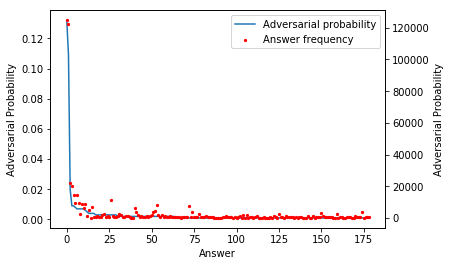

Time to run 0.407139062881
Success :  0 attemped :  0


In [4]:


import tqdm
from tqdm import tqdm
import time
from imageModel import ImageSaver
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torchvision.transforms as transforms
import pickle
import operator


model.train(False)
vocab_size = adv_dset.dictionary.ntoken

# labels_freq = {}
# for i in answers:
#     for j in i['labels']:
#         if j in labels_freq.keys():
#             labels_freq[j] += 1
#         else:
#             labels_freq[j] = 1


labels_freq = pickle.load(open('freq.p','rb'))
freq = sorted(labels_freq.items(), key=operator.itemgetter(1))
print label2ans[freq[-1][0]], freq[-1][1]

print(len(labels_freq.keys()))
# for param in model.parameters():
#     param.requires_grad = False
    
# file = open("add_word_res.txt","w")
file = None
attempted = 0
success = 0
start = time.time()

predicted = []
for i in tqdm(range(0)):
    entry = adv_dset.entries[i] 
    q_id, img_id = entry['question_id'], entry['image_id']
    v,b,q,a = adv_dset[i]
#     img_orig = v.clone()
#     img = ImageSaver('data').transform(img_orig)
    a_numpy = a.numpy()
    incorrect = np.where(a_numpy == 0)[0]
    correct =  a_numpy.nonzero()[0]
#     print b.size()
    v = v.unsqueeze(0)
    b = b.unsqueeze(0)
    q = q.unsqueeze(0)
    q_fool = q.clone()
    a = a.unsqueeze(0)
#     print(v.size())
#     v.requires_grad_()
#     print v.size()
    pred = model(v.cuda(), b.cuda(), q_fool.cuda(), None)  
    predicted_label = int(torch.max(pred,1)[1].data)
    probs = nn.Softmax(dim=1)(pred)
#     pred[0][predicted_label].backward()
#     v_grad = torch.squeeze(v.grad, dim=0)
#     v_grad_orig = torch.max(torch.abs(v_grad),dim=0)[0].numpy()
#     v_grad = v_grad/torch.max(v_grad)
#     v_grad = torch.max(v_grad, torch.Tensor([0.5]))
#     v_grad = torch.unsqueeze(v_grad, dim=0)
#     img_new = torch.cat((img_orig, v_grad), dim = 0)
#     img_new = transforms.ToPILImage()(img_new)
#     plt.imshow(img_new)
#     plt.show()
#     print "img_overlay"
#     print "grad", v_grad.size()
#     v_grad = torch.unsqueeze(v_grad,dim=0).numpy()
#     img = transforms.ToPILImage()(v_grad)
    
#     v.grad.data.zero_()

#     if predicted_label not in set(correct):
#         continue
    start_idx = 0
#     print("Image Id : " + str(img_id) + " Question Id : " + str(q_id) )
#     print  label2ans[predicted_label], float(probs[0,predicted_label].data)
    for i in xrange(q.size()[1]):
        if int(q[0,i].data) < len(adv_dset.dictionary.idx2word):
            0 == 0
#             print idx2word[int(q[0,i].data)],
        else:
            start_idx = i
#     print(start_idx, q_fool[0,start_idx], vocab_size)
#     print "\nCorrect answer: ",
#     for label in correct:
#         print label2ans[label] + " ", 
    attempted +=1
    for index in np.random.permutation(vocab_size)[0:100]: 
        with torch.no_grad():    
            q_fool[0,start_idx] = index
        
        pred = model(v.cuda(), b.cuda(), q_fool.cuda(), None)
        predicted_label = int(torch.max(pred,1)[1].data)
        if predicted_label not in set(correct):
#             pred[0][predicted_label].backward()
#             v_grad = torch.squeeze(v.grad, dim=0)
#             v_grad = torch.max(torch.abs(v_grad),dim=0)[0].numpy()
#             plt.imshow(img)
#             plt.show()
#             plt.imshow(v_grad_orig, cmap=plt.cm.hot)
#             plt.show()
#             plt.imshow(v_grad, cmap=plt.cm.hot)
#             plt.show()
#             print "\n",v.grad.data.size()
            probs = nn.Softmax(dim=1)(pred)
            predicted.append(predicted_label)
#             print "\nPredicted answer: " + label2ans[predicted_label], float(probs[0,predicted_label].data)
#             print "Adding word : " + idx2word[index]
            success += 1
            break
#         v.grad.data.zero_()
#     print("\n------------------------------------------------------------------------\n")

print(len(predicted))

pred_set = {}
for p in predicted:
    if p in pred_set.keys():
        pred_set[p] += 1
    else:
        pred_set[p] = 1
        
# freq_dict = dict(freq)
# pred_freq = sorted(pred_set.items(), key=operator.itemgetter(1))


pred_freq = pickle.load(open('pred_freq.p','rb'))
freq_dict = pickle.load(open('freq_dict.p','rb'))

# x = []
# y = []
# for i in range(1,20):
# #     print label2ans[pred_freq[-i][0]], pred_freq[-i][1], freq_dict[pred_freq[-i][0]]
#     y.append(pred_freq[-i][1])
#     x.append(freq_dict[pred_freq[-i][0]])

x = []
y = []
y2 = []
it = 0

# pred_s =  sorted(pred_freq.items(), key=operator.itemgetter(1))
for i in pred_freq[::-1]:
    x.append(it)
    y.append(1.0 * i[1]/1000)
    y2.append(freq_dict[i[0]])
    it += 1
print len(x), len(y)
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(x,y,label='Adversarial probability')
ax1.set_xlabel("Answer")
ax1.set_ylabel("Adversarial Probability")
ax2 = ax1.twinx()
ln2 = ax2.scatter(x,y2,s=5,c='r', label='Answer frequency')
ax2.set_ylabel("Adversarial Probability")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()
print "Time to run", time.time() - start
print "Success : ", success, "attemped : ", attempted

100%|██████████| 1000/1000 [02:01<00:00,  8.26it/s]


682
169 169


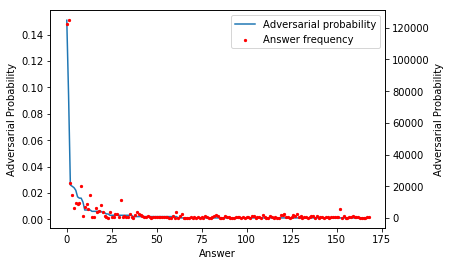

121.333166838
Sucess :  682 attemped :  1000


In [5]:
import tqdm
import copy
from tqdm import tqdm
import time
import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import torch.nn as nn

model.train(False)
idx2word = adv_dset.dictionary.idx2word
stopwords = set(stopwords.words('english')) | set(["?","\'s","going","number","made","take","cat","dog"])
vocab_size = adv_dset.dictionary.ntoken
# file = open("add_word_res.txt","w")
file = None
attempted = 0
success = 0
start = time.time()
attempt = 0
success = 0
predicted = []
for i in tqdm(range(1000)):
    entry = adv_dset.entries[i] 
    q_id, img_id = entry['question_id'], entry['image_id']
    v,b,q,a = adv_dset[i]
    a_numpy = a.numpy()
    incorrect = np.where(a_numpy == 0)[0]
    correct =  a_numpy.nonzero()[0]
    v = v.unsqueeze(0)
    b = b.unsqueeze(0)
    q = q.unsqueeze(0)
    q_fool = q.clone()
    a = a.unsqueeze(0)
    pred = model(v.cuda(), b.cuda(), q_fool.cuda(), None)
    probs = nn.Softmax(dim=1)(pred)
    predicted_label = int(torch.max(pred,1)[1].data)
    if predicted_label not in set(correct):
        continue    
#     print "Image Id : " + str(img_id) + " Question Id : " + str(q_id)  
    sent = []
    len_sent = 0
    for i in xrange(q.size()[1]):
        if int(q[0,i].data) < len(adv_dset.dictionary.idx2word):
#             print idx2word[int(q[0,i].data)],
            len_sent += 1
            sent.append(idx2word[int(q[0,i].data)])
        else:
            sent.append("_")
#     print "?", label2ans[predicted_label], float(probs[0,predicted_label].data)
    
    attempt += 1
    for i in xrange(q.size()[1]):
        if int(q[0,i].data) < len(adv_dset.dictionary.idx2word):
            w = idx2word[int(q[0,i].data)]
            q_fool = q.clone()
            if w in stopwords:
                continue
            done = False
            for syn in wordnet.synsets(w):
                for l in syn.lemmas():
                    if str(l.name()) in word2idx and str(l.name()) != w:
                        q_fool = q.clone()
                        q_fool[0,i] = word2idx[str(l.name())]
                        pred = model(v.cuda(), b.cuda(), q_fool.cuda(), None)
                        probs = nn.Softmax(dim=1)(pred)
                        predicted_label = int(torch.max(pred,1)[1].data)
#                         print l.name(), word2idx[str(l.name())], label2ans[predicted_label]
                        if predicted_label not in correct:
                            predicted.append(predicted_label)
                            success += 1
                            adv_sent = copy.deepcopy(sent)
                            adv_sent[i] = str(l.name())
#                             print " ".join(adv_sent[-len_sent:]), "?", label2ans[predicted_label], float(probs[0,predicted_label].data)
                            done = True
                            break
                if done:
                    break
#     print(start_idx, q_fool[0,start_idx], vocab_size)
#     print "Correct answer: ",
#     for label in correct:
#         print label2ans[label],
#     print("\n------------------------------------------------------------------------\n")

print(len(predicted))

pred_set = {}
for p in predicted:
    if p in pred_set.keys():
        pred_set[p] += 1
    else:
        pred_set[p] = 1
        
# freq_dict = dict(freq)
pred_freq = sorted(pred_set.items(), key=operator.itemgetter(1))

x = []
y = []
y2 = []
it = 0

# pred_s =  sorted(pred_freq.items(), key=operator.itemgetter(1))
for i in pred_freq[::-1]:
    x.append(it)
    y.append(1.0 * i[1]/1000)
    y2.append(freq_dict[i[0]])
    it += 1
print len(x), len(y)
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ln1 = ax1.plot(x,y,label='Adversarial probability')
ax1.set_xlabel("Answer")
ax1.set_ylabel("Adversarial Probability")
ax2 = ax1.twinx()
ln2 = ax2.scatter(x,y2,s=5,c='r', label='Answer frequency')
ax2.set_ylabel("Adversarial Probability")
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
plt.show()
print time.time() - start
print "Sucess : ", success, "attemped : ", attempt